---
title: Predicting cloud movements
author: Stefan
date: 2018-07-16
categories:
  - Python
tags:
  - LSTM
  - Python
  - CNN
  - Keras
  - time-series
  - Deep_learning
---

In this notebook we will attempt to predict or forecast the movement of rain/clouds over the area of North America!

Of course the weather is a known chaotic system, therefore we will try to create an initial benchmark by throwing a deep learning model at the problem.

The images can be downloaded from AWS S3 using the following link <https://s3-eu-west-1.amazonaws.com/data-problems/precipitation_data.zip>

## Import some libraries

In [29]:
import os
from os import listdir
from PIL import Image as PImage
import matplotlib.pyplot as plt
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.image as img
import PIL as Image
from keras.preprocessing.image import ImageDataGenerator
import sys
from keras.callbacks import TensorBoard
print(sys.version)

3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 12:30:02) [MSC v.1900 64 bit (AMD64)]


## Example input

The images downloaded from S3 will look like this:

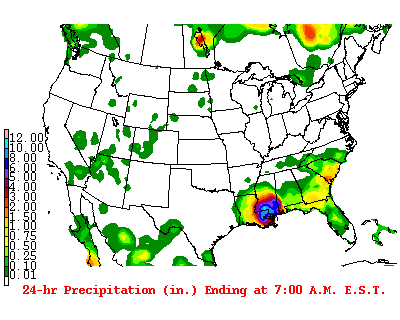

In [30]:
path = "C:/Users/User-pc/Desktop/Work/Git_Repositories/Precipitation_Forecast/Data/precipitation_data/data/"
path_out = "C:/Users/User-pc/Desktop/Work/Git_Repositories/Precipitation_Forecast/Data/precipitation_data/data_cleaned/"

im = PImage.open(path+'20120830.gif').convert('RGB')
im


### Observations

- Static images not animated even though they are .gif
- CSV file containing the lag between the date of shown image and the date the image was taken. Not always consistent!
- For image data deeplearning is almost surely the solution for the moment. Also we are dealing with stochastic datapoints so probably need to use a recurrent network.
- These images have metadata in them we dont want. The index on the left and the text at the bottom might change and lead to false signal in the model
- User of our model wants to provide images to it and get predictions. We need to have clear modules for processing input data for our model
- Color channel of image input could be useful actually... We could remove anything that isnt moving from these images. Our predictions will only be clouds but whatever, should be easier to train and easy enough to put ontop of a geospatial shape file layer
- Images are 400 by 320. We may want to reduce the size with our data import module
- Since we will be predicting images not labels or scores we are building something similar to an autoencoder

Based on a 2 second google search my assumptions were somewhat validated over here: http://blog.kaggle.com/2016/01/04/how-much-did-it-rain-ii-winners-interview-1st-place-pupa-aka-aaron-sim/

**Possible insights**

- We could use dropin to perturb the input images beyond just data generators in keras. Instead of rotating the images we can duplicate certain sub frames to teach the network that time could have moved at different rates and still achieved same output image.
- With images flowing in we could achieve this by duplicating images at random before creating our lagged prediction images

I will have to edit these images so I need to remember how to use the PILLOW library: https://www.youtube.com/watch?v=6Qs3wObeWwc

## Clean images before we start

This function will load all images in a folder and then clean all the pixels we aren't interested in

In [31]:
def cleanImages(path,new_path):
    # return array of images

    imagesList = listdir(path)
    for image in imagesList:
        if(image.endswith('.gif')):
            fname,fext = os.path.splitext(image)
            im = PImage.open(path + image).convert('RGB')
            width, _ = im.size
            for i, px in enumerate(im.getdata()):
                y = i / width
                x = i % width
                if (px == (0,0,0)):
                    im.putpixel((x, y), (255,255,255))
                if ((x<4*400/100)or(_*0.88<y)):
                    im.putpixel((x, y), (255,255,255))
            im.save(new_path+image)          

The function is very simple. The function will remove all black pixels from the image (the shapefiles) and also crop away the legend and sub title of the images that we are not interested in.

This is what the output images will look like:

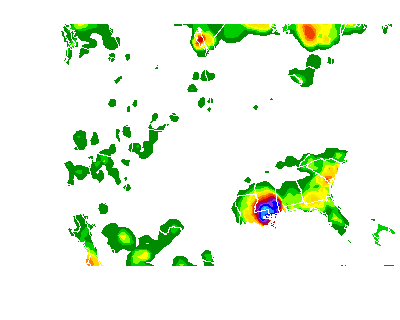

In [32]:
im = PImage.open(path_out+'20120830.gif')
im

Since we are going to use a deep learning model to do the predictions we don't need to do too much feature engineering. For now this will be enough to server our purposes.

Now it's time to get the data ready for a deep learning model.

## Deep learning model

### Choice of model

For our final model we will almost surely need to use a recurrent neural network. The reason is simply that we are trying to predict using stochastic data. We also need to consider that we are dealing with image data. One of the best network architectures for images convolutional network layers.

For our initial test we can simply build a convolutional network to train on the data. This help formalize the data preparation process

### Convolutional network

For a convolutional network we need to provide a 3 dimensional tensor where our shape is defined (samples,width,height,channels), where channels depict the RGB color value of each pixel.

Matplotlib.img has a useful tool for reading in images as unmpy arrays. Each of these imported images will be of shape (width,height,channels). To prepare for our convolutional network we need to have another dimension for the samples.

Note that the convention is to use img_to_array(load_img(new_path+image)) using the keras library. This is just a bit more vebose than what I used. This workflow can be more powerful if we intend to use generators to apply transformations to the immages.

We produce the data using a simple list comprehension:

In [33]:
%%time
new_path = "C:/Users/User-pc/Desktop/Work/Git_Repositories/Precipitation_Forecast/Data/precipitation_data/data_cleaned_jpeg/"
path_orig = "C:/Users/User-pc/Desktop/Work/Git_Repositories/Precipitation_Forecast/Data/precipitation_data/data/"
path_cleaned = "C:/Users/User-pc/Desktop/Work/Git_Repositories/Precipitation_Forecast/Data/precipitation_data/data_cleaned/"

imagesList = os.listdir(new_path)

training_data = np.array( [img.imread(new_path+image) for image in imagesList])

Wall time: 5.35 s


This takes about 5 seconds because we have quite a few images in here:

In [34]:
len(imagesList)

2383

Let's make sure we have the right shape for our 4D tensor:

In [35]:
training_data.shape

(2383, 320, 400, 3)

Before we throw these numpy arrays at our deep learning model it is important to scale our inputs between [0,1]. The obvious reason is that standard convention to scale inputs helps against exploding model weights. In our case it is also important because we will use a crossentropy method to measure the accuracy of our model. This wouldn't make sense if our values weren't between [0,1].

It's also a good idea to make sure your values are float32 (or float16 when working with a GPU that has tensorcores)

Let's scale this 4D tensor:

In [36]:
training_data = np.divide(training_data,255)

The time interval that we have images for is Jan 2012 to 10 July 2018 (the time I downloaded the images):

In [37]:
print(imagesList[0],imagesList[-1])

20120101.jpg 20180710.jpg


We can also see that we have one image for each day:

In [38]:
imagesList[0:5]

['20120101.jpg',
 '20120102.jpg',
 '20120103.jpg',
 '20120104.jpg',
 '20120105.jpg']

For our first network we will simply predict the next day's satellite image. To do this we set the input X to be the 1 day lagged images:

In [39]:
train_len = int(np.floor(len(training_data)*0.75))
test_len = int(np.floor((len(training_data)-train_len) * 0.5))
val_len = int(len(training_data)-test_len-train_len)

print(train_len,test_len,val_len)

1787 298 298


In [40]:
train_split = training_data[0:train_len]
test_split = training_data[train_len:train_len+test_len]
val_split = training_data[train_len+test_len:len(training_data)]

print(len(train_split),len(test_split),len(val_split))

1787 298 298


In [46]:
X = train_split[0:len(train_split)-1,:,:,:]
Y = train_split[1:len(train_split),:,:,:]

X_val = val_split[0:len(val_split)-1,:,:,:]
y_val = val_split[1:len(val_split),:,:,:]

In [48]:
print(len(X),len(Y),len(X_val),len(y_val))

1786 1786 297 297


We split off some data for validating our training and we also split off some data to validate our model after we have tuned the parameters. The test data is important if we intend to tune the model often to maximise our validation accuracy. After a few iterations we are leaking some knowledge about the preformance of the model on the validation data.

### Define model

For our initial model I define a simple stacked network of 3 convolutional layers. Normally we would use layers like max pooling to reduce the complexity of our model. This won't be needed because we are not going to use all too many layers and we are predicting images of the same size; max pooling will extract and combine local features but then we would need to widen our units in the layers to get back to the predicted image.

To use max_pooling we would use MaxPooling2D((2,2)) and UpSampling2D((2,2)) to return to the same dimensions

In [54]:
conv_model = Sequential()
conv_model.add(Conv2D(3,(3,3),input_shape=(320, 400, 3), activation='relu',padding='same'))
conv_model.add(Conv2D(3,(3,3),input_shape=(320, 400, 3), activation='relu',padding='same'))
conv_model.add(Conv2D(3,(3,3),input_shape=(320, 400, 3), activation='relu',padding='same'))

conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 320, 400, 3)       84        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 320, 400, 3)       84        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 320, 400, 3)       84        
Total params: 252
Trainable params: 252
Non-trainable params: 0
_________________________________________________________________


For this kind of prediction I will use an optimizer very similar to the optimizers used for auto encoding. Since each pixel in our model is now scaled between [0,1] instead of [0,255] we can use a binary_crossentropy to optimize our fit:

In [55]:
conv_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
#               optimizer='adadelta'
#               metrics=['accuracy']
                  )

In [56]:
history = conv_model.fit(X, Y,
                epochs=10,
                validation_data=(X_val, y_val)
#                 callbacks=[TensorBoard(log_dir='C:/Users/User-pc/Desktop/Work/Git_Repositories/Precipitation_Forecast/tensorboard')]
               )

Train on 1786 samples, validate on 297 samples
Epoch 1/10
1786/1786 [==============================] - 15s - loss: 2.2330 - val_loss: 0.5243

Plot the loss:

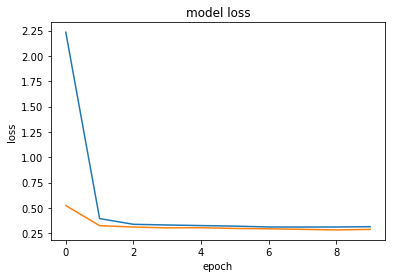

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

So we can see the we don't seem to have issues of over fitting the data. This isn't really my concern right now since we first need to achieve a model able to predict future movements of clouds. So on that note, let's investigate the output of the model more closely:

#### Example input

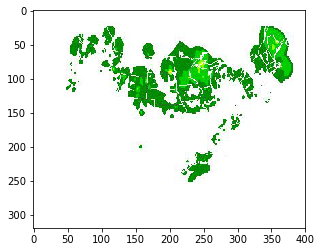

In [58]:
imgplot = plt.imshow(X[0])
plt.show()

#### Example predicted next image:

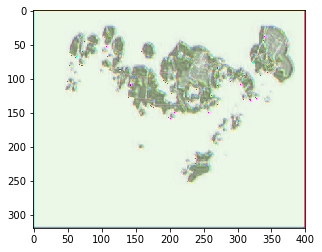

In [63]:
predict_img = conv_model.predict(X[0:5])

imgplot = plt.imshow(predict_img[0])
plt.show()

#### What really happened

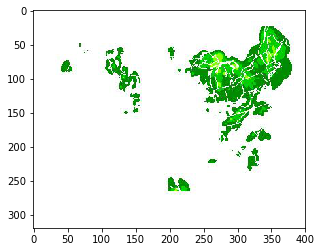

In [65]:
real_img = Y[0:5]
imgplot = plt.imshow(real_img[0])
plt.show()

So our naive model hasn't really learned anything impressive

### Convolutional LSTM network

In [82]:
new_path = "C:/Users/User-pc/Desktop/Work/Git_Repositories/Precipitation_Forecast/Data/precipitation_data/data_cleaned_jpeg/"
path_orig = "C:/Users/User-pc/Desktop/Work/Git_Repositories/Precipitation_Forecast/Data/precipitation_data/data/"
path_cleaned = "C:/Users/User-pc/Desktop/Work/Git_Repositories/Precipitation_Forecast/Data/precipitation_data/data_cleaned/"

imagesList = os.listdir(new_path)

# training_data = np.array( [img.imread(new_path+image) for image in imagesList])
training_data = np.array([img_to_array(load_img(new_path+image)) for image in imagesList])


In [83]:
training_data = np.divide(training_data,255)

For this recurrent structure I want to go up from a 4D tensor input to a 5D tensor. The new dimension is the time index.

Theoretically that means having observations where each observation is a sequence of images. In our case an observation should be a week of images, such that we are in fact predicting the next week of images.

In [84]:
train_split = training_data[0:train_len]
test_split = training_data[train_len:train_len+test_len]
val_split = training_data[train_len+test_len:len(training_data)]

In [85]:
len(train_split)%7

2

Currently we will have 2 days that do not fit into a full week. For now we will simply remove these images:

In [86]:
train_split = np.delete(train_split,[i for i in range(len(train_split)%7)],axis=0)
test_split = np.delete(test_split,[i for i in range(len(test_split)%7)],axis=0)
val_split = np.delete(val_split,[i for i in range(len(val_split)%7)],axis=0)

Now that we have full weeks in our data we need to stack these 4D tensors for our sequence dimension:

In [ ]:
%%time
week_data_train = []
while(len(train_split)>6):
    week = np.array([train_split[k] for k in range(7)])
    week_data_train.append(week)
    train_split = np.delete(train_split,[i for i in range(7)],axis=0)
    
week_data_train = np.array(week_data_train)

In [102]:
%%time
week_data_test = []
while(len(test_split)>6):
    week = np.array([test_split[k] for k in range(7)])
    week_data_test.append(week)
    test_split = np.delete(test_split,[i for i in range(7)],axis=0)
    
week_data_test = np.array(week_data_test)

Wall time: 4.56 s


We can verify that we now have a 5D tensor to train on:

In [104]:
week_data_train.shape

(255, 7, 320, 400, 3)

So we can train on 255 full weeks worth of data

In [105]:
X = week_data_train[0:len(week_data_train)-1]
Y = week_data_train[1:len(week_data_train)]

X_val = week_data_test[0:len(week_data_test)-1]
y_val = week_data_test[1:len(week_data_test)]


#### Define network

For this recurrent network we still want to use convolutional layers so I will use the handy keras layer called ConvLSTM2D. It will train a long short term memory network using convolutions. We will also specify go_backwards=True in order to use a bidirectional recurrent layout.

In [106]:
conv_model = Sequential()
conv_model.add(ConvLSTM2D(3,kernel_size=(3,3),input_shape=(7,320, 400, 3),padding='same', return_sequences=True,go_backwards=True))
conv_model.add(ConvLSTM2D(3,kernel_size=(3,3),padding='same', return_sequences=True,go_backwards=True))

conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_5 (ConvLSTM2D)  (None, 7, 320, 400, 3)    660       
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, 7, 320, 400, 3)    660       
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [112]:
conv_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
#               metrics=['accuracy']
                  )

Here I use a batch_size of 8 because any larger gave me out of memory errors.

In [113]:
%%time
history = conv_model.fit(X, Y,
                epochs=10,
                batch_size = 8,
                shuffle = False
                ,validation_data=(X_val, y_val)
               )

Train on 254 samples, validate on 41 samples
Epoch 1/10
254/254 [==============================] - 46s - loss: 5.5493 - val_loss: 4.9973

Note that we specify Shuffle = False since the sequence is important

In [114]:
conv_model.save('CNN_LSTM_bidirectional_10epochs.h5')

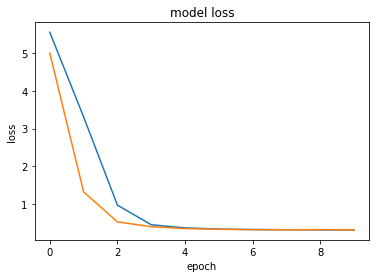

In [115]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [116]:
predict_img = conv_model.predict(X[0:1])
real_img = Y[0:1]

So our first week of images were:

In [119]:
fig=plt.figure(figsize=(320, 400))
for i in range(1, 7 +1):
#     img = plt.imshow()
    fig.add_subplot(8, 1, i)
    plt.imshow(X[0,i-1])
plt.show()

And we predicted this would happen:

In [120]:
fig=plt.figure(figsize=(320, 400))
for i in range(1, 7 +1):
#     img = plt.imshow()
    fig.add_subplot(8, 1, i)
    plt.imshow(predict_img[0,i-1])
plt.show()

This is actually very promising... Our model is starting to make some novel predictions in new areas.

This is what we were suppose to see:

In [121]:
fig=plt.figure(figsize=(320, 400))
for i in range(1, 7 +1):
#     img = plt.imshow()
    fig.add_subplot(8, 1, i)
    plt.imshow(real_img[0,i-1])
plt.show()

#### Zoom in on final image:

**Input**

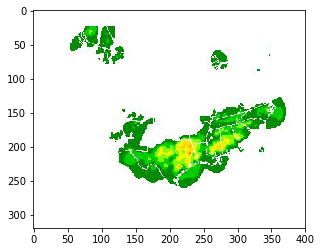

In [122]:
imgplot = plt.imshow(X[0,6])
plt.show()

**Predicted**

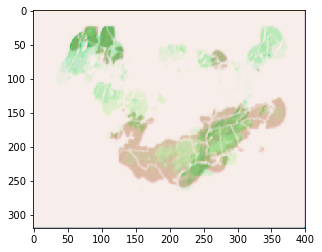

In [123]:
imgplot = plt.imshow(predict_img[0,6])
plt.show()

**Actual future**

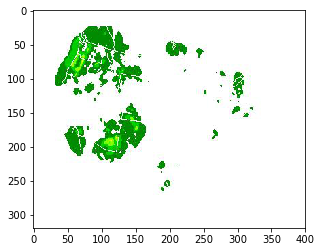

In [124]:
imgplot = plt.imshow(real_img[0,6])
plt.show()

## Conclusions

My initial impression is that the current model really struggles to predict anything other than what it sees right now. Even so with our reccurrent network we started seeing some novel predictions.

All in all I'm not too surprised! The data we gave the model is only 1 image per day. Perhaps if we had access to 24 images per day the hour on hour move of pixels would be more informative.

The model does not yet have any context for what the color of the pixels may be in the future either.

Perhaps with a scaled up version of the model and more training we will see a better prediction. But more likely we need to start creating our own network graphs and loss functions. Currently we are optimizing mean binary crossentropy over all the pixels - a better loss function will measure binary crossentropy over a max_pooling of the output. Perhaps we can even define a pooling of pixels that uses a MAX instead of an average to help against all the empty space.